# **Udacity Capstone Project: Sparify**

# Part 1: Project Overview and Problem Statement

Many online services make use of subscriptions where users pay monthly for a product that they are using. When the platform is online, it can be profitable to implement a "freemium" model where the service is free to the population (usually with ads) and the subscription allows for the removal of ads.

In such situations, being able to predict when a user will unsubscribe so that they can be targeted with promotions to try and convince them to stay can reduce loss of potential revenue over time. In this dataset, the actions for a given user have been recorded and will be used towards this end.

However, online platforms tend to generate high volumes of data that can be difficult to keep in memory. Big data solutions such as Spark can help to distribute the workload among several computers, allowing machine learning to be done on larger datasets.

Thus, we will use Spark in this project to help with our aim of creating a ML model to predict churn on a user level.

# Part 2: Preparatory Analysis

Before doing any machine learning, it is important to load the dataset, perform some cleaning, and do some basic investigation.

Depending on correlations, we can decide which features we would like to use in our model (feature selection) and we can also decide which features can be combined or infered to create new features that might provide useful information (feature engineering).


## Data Importation and Workspace Setup

Below, packages required for this problem will are imported as well as other prepwork for the project.

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Cleaning and analysis will be done on this smaller dataset before doing anything with the larger dataset.

### Import Libraries

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import os
from tqdm import *

from time import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col

from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

plt.style.use("seaborn")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Define Functions

In [2]:
def print_cm(tp, tn, fp, fn, print_cm=True, return_cm=False):
    """
    Print confusion matrix given tp, tn, fp and fn.
    
    Note that array is in following order tp, fp, fn, tn. (Row, across)
    
    :Inputs:
        :tp: Int, True positives
        :tn: Int, True Negatives
        :fp: Int, False Positives
        :fn: Int, False Negatives
        :print_cm: Bool, if true then prints cm
        :return_cm: Bool, if true then returns cm
    :Returns:
        :cm: Confusion matrix as numpy array
    """
    
    cm = np.array([[tp, fp],
                   [fn, tn]])

    if print_cm:
        print(cm)
    
    if return_cm:
        return cm

In [3]:
def get_classification_score(tp, tn, fp, fn, print_stats=True, return_stats=False):
    """
    Prints classification scores given tp, tn, fp and fn.
    
    :Inputs:
        :tp: Int, True positives
        :tn: Int, True Negatives
        :fp: Int, False Positives
        :fn: Int, False Negatives
        :print_stats: Bool, if true then prints stats
        :return_stats: Bool, if true then returns stats
    :Returns:
        :accuracy: Number of correct classifications over number of classifications
        :precision: Number of true positives out of positive classifications
        :recall: Number of true positives out of those that should have been true positives
        :f1: Harmonic mean of precision and recall, good overall stat
    """
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    try: precision = tp / (tp + fp) 
    except ZeroDivisionError: precision = np.NaN

    try: recall = tp / (tp + fn)
    except ZeroDivisionError: recall = np.NaN
    
    try: f1 = 2*precision*recall / (precision+recall)
    except ZeroDivisionError: f1 = np.NaN
        
    if print_stats:
        print("_________________")
        print("Confusion Matrix:")
        print("\tAccuracy:", accuracy)
        print("\tPrecision:", precision)
        print("\tRecall:",recall)
        print("\tF1 Score:", f1)
        print("_________________")
        
    if return_stats:
        return accuracy, precision, recall, f1

### Spark Setup

In [4]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist();

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Showing a sample of the dataset
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

I personally like taking a look at the head of a RDD by using the `show` method and then copying and pasting the preformatted table that gets printed out into notepad++ or any other code editor. I personally find it more readable than showing a head like above.

In [8]:
# Showing a sample of the dataset
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 


We can already see that there are 12 columns in our data set.

In [9]:
# Get a quick description of the dataset
spark_description = df.describe().collect()

# Create Dict for Description Dataframe (Doing this for easy viewing)
description_dict = dict()
for i in spark_description:
    
    # Turn i into dictionary
    i = i.asDict()
    
    for k, v in i.items():
        try:
            description_dict[k].append(v)
        except KeyError:
            description_dict[k] = []
            description_dict[k].append(v)

# Create dataframe and reshape
df_desc = pd.DataFrame(description_dict).T.reset_index()
df_desc.columns = df_desc.iloc[0]
df_desc = df_desc[1:]

df_desc

,summary,count,mean,stddev,min,max
1,artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
2,auth,286500,None,None,Cancelled,Logged Out
3,firstName,278154,None,None,Adelaida,Zyonna
4,gender,278154,None,None,F,M
5,itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
6,lastName,278154,None,None,Adams,Wright
7,length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
8,level,286500,None,None,free,paid
9,location,278154,None,None,"Albany, OR","Winston-Salem, NC"
10,method,286500,None,None,GET,PUT


## Data Cleaning

### First Looks

Now that the data has been imported, the first and most obvious thing to check for is missing and duplicated values. 

Since I am relatively comfortable with SQL, I will try and use that a little. In order to do that I need to create a temp view within the spark object that created the dataframe using the `createOrReplaceTempView` method.

In [10]:
# Create Temp View
df.createOrReplaceTempView("df")

Now that this is complete, we can look at the null values for each column.

In [11]:
null_dict = {}

for i in df.columns:
    
    nulls = spark.sql("SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS null_{} \
                    FROM df \
                    where {} is null".format(i, i, i)).collect()[0]["null_{}".format(i)]
    
    print(i, nulls)
    null_dict[i] = nulls

artist 58392
auth None
firstName 8346
gender 8346
itemInSession None
lastName 8346
length 58392
level None
location 8346
method None
page None
registration 8346
sessionId None
song 58392
status None
ts None
userAgent 8346
userId None


We can see that there are 58k rows where the artist and song names are null. This could be because in this instance, the page that was visited was not intended to play a song. 

We can also see that there are several columns which are never null;

* auth
* itemInSession
* level
* method
* page
* sessionId
* status
* ts
* userId

This tells us that we have users who commit actions during a session. So, the unique key should be something like (userId, ts). We can quickly verify that:

In [12]:
# Test for unique key
spark.sql("SELECT userId, ts, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2\
        HAVING count(*) > 1 \
        ORDER BY 3 DESC \
        LIMIT 10").collect()

[Row(userId='98', ts=1538838475000, n_rows=3),
 Row(userId='95', ts=1539665400000, n_rows=3),
 Row(userId='100022', ts=1541463867000, n_rows=3),
 Row(userId='', ts=1538488477000, n_rows=2),
 Row(userId='118', ts=1540521007000, n_rows=2),
 Row(userId='152', ts=1543206099000, n_rows=2),
 Row(userId='30', ts=1543436963000, n_rows=2),
 Row(userId='36', ts=1539070836000, n_rows=2),
 Row(userId='9', ts=1539714540000, n_rows=2),
 Row(userId='132', ts=1542791668000, n_rows=2)]

In [13]:
# Find number of userid-timestamp combinations that have duplicated rows
spark.sql("WITH T AS (SELECT userId, ts, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2\
        HAVING COUNT(*) > 1 \
        ORDER BY 3 DESC \
        ) \
        SELECT COUNT(*) FROM T").collect()

[Row(count(1)=783)]

### Remove Duplicates

We can see here that my assertion was wrong and that we have almost 800 userId-ts combinations that have at least 2 entries. We can view an example as well using the query below...

In [14]:
# Get an example with duplicated rows
spark.sql("SELECT * \
        FROM df \
        WHERE userId = 98\
        AND ts = 1538838475000").collect()

[Row(artist='Mase', auth='Logged In', firstName='Sawyer', gender='M', itemInSession=70, lastName='Larson', length=255.16363, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=493, song="Lookin' At Me [feat. Puff Daddy] (Album Version)", status=200, ts=1538838475000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist=None, auth='Logged In', firstName='Sawyer', gender='M', itemInSession=71, lastName='Larson', length=None, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='GET', page='Home', registration=1538069638000, sessionId=493, song=None, status=200, ts=1538838475000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist=None, auth='Logged In', firstName='Sawyer', gen

In this example we can see that the user went to the next song before visiting the home page twice all with the same timestamp. It's a little difficult to know what to do in this situation.

If we were to be joining tables then not knowing the primary key would result in the duplication of values. We won't be doing any joins with this data and so that is not an issue.

However, it might introduct noise for our ML model if we have duplicate rows. Hence, it would be worth dropping page visits that happen multiple times for the same userId and ts. This is because visiting the same page within the same timestamp, while it may not strictly be duplicated, can probably be viewed as such as it provides no more interesting information about a user. 

In [15]:
# Find the unique key
spark.sql("WITH T AS (SELECT userId, ts, itemInSession, page, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2, 3, 4\
        HAVING count(*) > 1 \
        ORDER BY 5 DESC \
        ) \
        SELECT COUNT(*) AS n_duplicated FROM T").collect()

[Row(n_duplicated=0)]

Finally we have found the unique key. It is userId, ts, itemInSession, page. This is because the for each user they might visit multiple pages within a certain timestamp. However, for each page that they load the itemInSession is iterated.

However, there is once instance where the itemInSession was duplicated, meaning that the unique key is only achieved once the page is also taken into consideration.

This is a little unexpected because it should not be technically possible to visit multiple pages within the same timestamp. So what we'll do is we'll rank the rows and keep only the timestamps with the lowest itemInSession count per user. (For the one event that was duplicated, we'll just pick a row at random.)

In [16]:
df_unique = spark.sql("WITH T AS (SELECT *, ROW_NUMBER() OVER (PARTITION BY userId, ts ORDER BY itemInSession) as rank\
                    FROM df ) \
                    SELECT * FROM T \
                    WHERE rank = 1")

# Create Temp View
df_unique.createOrReplaceTempView("df_unique")

In [17]:
# Verify clean successful
spark.sql("WITH T AS (SELECT userId, ts, itemInSession, count(*) AS n_rows \
        FROM df_unique \
        GROUP BY 1, 2, 3\
        HAVING count(*) > 1 \
        ORDER BY 4 DESC \
        ) \
        SELECT COUNT(*) AS n_duplicated FROM T").collect()

[Row(n_duplicated=0)]

Very good! We've gotten rid of events that happen on the same timestamp, which means that we've taken care of duplicated values.

In [18]:
df_unique.head(1)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=141, song=None, status=200, ts=1538391913000, userAgent=None, userId='', rank=1)]

### Missing Values

As investigated above, there are times when we get missing values. The only issue is that this can happen because the page is not playing an artist. Thus, we need to find a way to distinguish between instances where a missing value is acceptable and other times when it is not.

To remind ourselves of missing values, here are the instances where this was true below...

* artist: 58392
* firstName: 8346
* gender: 8346
* lastName: 8346
* length: 58392
* location: 8346
* registration: 8346
* song: 58392
* userAgent: 8346

We can see that the number of null `registration` are 8,346. This means that for the columns `firstName`, `gender`, `lastName`,
`location` and `userAgent` Likely do not contain any null values that cannot be explained by missing a registration.

The remaining two columns `song` and `artist` will be null then the page does not play music.

To assess whether it is necessary to take any action on nulls, the following tests should be carried out:

1. All registrations have non-null `firstName`, `gender`, `lastName`, `location` and `userAgent`
2. All non-registrations have null columns in these cases
3. All non-song-playing pages will have null `song` and `artist` and 
4. vice versa (as above)

In [19]:
# Vertify All registrations have non-null in relevant columns
nan_dict = {}

for i in ["firstName", "gender", "lastName", "location", "userAgent"]:
    returns = spark.sql("""
        SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS nulls 
        FROM df_unique
        WHERE registration IS NOT NULL
    """.format(i)).collect()
    
    nan_dict[i] = returns[0].nulls
    
print(nan_dict)

{'firstName': 0, 'gender': 0, 'lastName': 0, 'location': 0, 'userAgent': 0}


In [20]:
# Vertify All non-registrations *have* null in relevant columns
nan_dict = {}

for i in ["firstName", "gender", "lastName", "location", "userAgent"]:
    returns = spark.sql("""
        SELECT SUM(CASE WHEN {} IS NOT NULL THEN 1 ELSE 0 END) AS nulls
        FROM df_unique
        WHERE registration IS NULL
    """.format(i)).collect()
    
    nan_dict[i] = returns[0].nulls
    
print(nan_dict)

{'firstName': 0, 'gender': 0, 'lastName': 0, 'location': 0, 'userAgent': 0}


Alright! This is actually shaping up to be a relatively clean dataset!

Before we check the song and artist columns, we should make sure that we know which 

In [21]:
spark.sql("""
    SELECT page,
           COUNT(*)                                        AS n_rows,
           SUM(CASE WHEN song IS NULL THEN 1 ELSE 0 END)   AS null_songs,
           SUM(CASE WHEN artist IS NULL THEN 1 ELSE 0 END) AS null_artist
    FROM df_unique
    GROUP BY 1
""").collect()

[Row(page='Cancel', n_rows=52, null_songs=52, null_artist=52),
 Row(page='Submit Downgrade', n_rows=63, null_songs=63, null_artist=63),
 Row(page='Thumbs Down', n_rows=2546, null_songs=2546, null_artist=2546),
 Row(page='Home', n_rows=14235, null_songs=14235, null_artist=14235),
 Row(page='Downgrade', n_rows=2001, null_songs=2001, null_artist=2001),
 Row(page='Roll Advert', n_rows=3805, null_songs=3805, null_artist=3805),
 Row(page='Logout', n_rows=3226, null_songs=3226, null_artist=3226),
 Row(page='Save Settings', n_rows=310, null_songs=310, null_artist=310),
 Row(page='Cancellation Confirmation', n_rows=51, null_songs=51, null_artist=51),
 Row(page='About', n_rows=904, null_songs=904, null_artist=904),
 Row(page='Submit Registration', n_rows=5, null_songs=5, null_artist=5),
 Row(page='Settings', n_rows=1470, null_songs=1470, null_artist=1470),
 Row(page='Login', n_rows=3240, null_songs=3240, null_artist=3240),
 Row(page='Register', n_rows=18, null_songs=18, null_artist=18),
 Row(pag

We can see that the number of rows gives us the number of rows that should be null in the case that the page does not require that a song plays.

It seems that the only case where there are not nulls is in the case of `NextSong` where we don't expect the songs to be null.

Luckily, when this is the case, the rows are completely filled. So there does not seem to be any issues with null values that I can see.

## Exploratory Data Analysis

### Define Churn

Before asking questions and exploring our dataset it is important to give these questions direction via our goal, which is to predict which users will churn before they do so.

For this analysis we will define churned users as those who have a  `Cancelation Confirmation` event.


## Define Questions to be answered

Now that we know what information is important to us in this dataset here are some general questions

1. How many distinct users are there in our dataset?
3. Which pages are the most visited for each user?
4. What location are our users mostly from?
5. What does the gender distribution of our dataset look like?

### How many distinct users are there in our dataset?

In [22]:
spark.sql("""
    SELECT CASE WHEN registration IS NULL THEN 0 ELSE 1 END AS is_registered,
    COUNT(DISTINCT du.userId) 
    FROM df_unique AS du 
    GROUP BY 1
    ORDER BY 1

""").collect()

[Row(is_registered=0, count(DISTINCT userId)=1),
 Row(is_registered=1, count(DISTINCT userId)=225)]

Here, we can see that there are 226 users in total. For the data that we have, almost all of them are registered (225 to be precise). We also have one user in our dataset that is not registered.

### Which pages are the most visited for each user?

In [23]:
# Find non distinct visits
response = spark.sql("""
    SELECT page, COUNT(userId) AS counts
    FROM df_unique
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

pages_non_distinct_view = [i.page for i in response]
non_distinct_view = [i.counts for i in response]

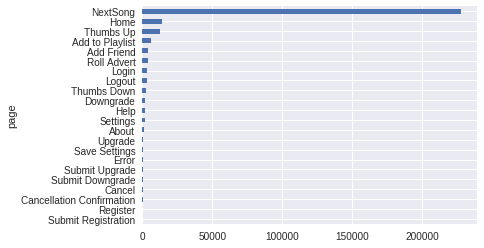

In [24]:
# Find visits for distinct users
response = spark.sql("""
    WITH user_pages AS (
        SELECT DISTINCT userId, 
                        page 
        FROM df_unique
    )
    
    SELECT page, COUNT(DISTINCT userId) AS counts
    FROM user_pages
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

distinct_view = [i.counts for i in response]

# Convert aggregated results to dataframe
df_page_vists = pd.DataFrame(dict(page = pages_non_distinct_view,
                                  distinct_view = distinct_view,
                                  non_distinct_view = non_distinct_view))

# Plot values from dataframe
ax = df_page_vists.sort_values("non_distinct_view").set_index("page")["non_distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();

We can see from this graph that users tend to use the service for playing music, obviously. They will also visit the home button a lot of times and rate music that they like. 

We can see that cancellation confirmations tend to be very unlikely, which means that our dataset after the feature engineering is complete will be imbalanced.

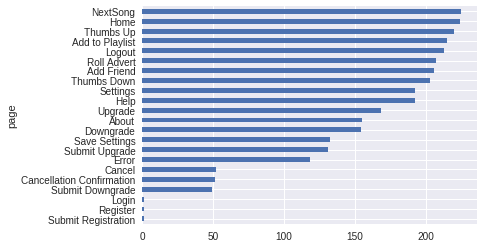

In [25]:
ax = df_page_vists.sort_values("distinct_view").set_index("page")["distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();

When we look for distinct users per page then things stop looking quite so imbalanced. We can see that out of roughly 225 registered users, roughly 50 of them end up downgrading.

I think when doing the feature engineering for this dataset, it will be worth trying to find values that provide more signal than things like "next song", which everyone does.

What's interesting is how the pages for logins, and registrations are relatively low which is something that I didn't expect.

It might be that other features are better correlated with cancellation confirmation. We want page visits that happen frequently, but not so frequently that they become meaningless.

### What location are our users mostly from?

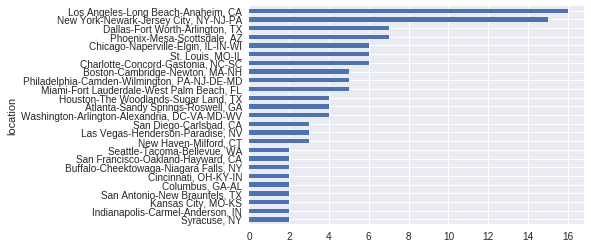

In [26]:
response = spark.sql("""
    WITH user_locations AS (
        SELECT DISTINCT userId, 
                        location 
        FROM df_unique
    )
    
    SELECT location, COUNT(DISTINCT userId) AS counts
    FROM user_locations
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 25  -- Note that without a limit, the graph will overplot
""").collect()

location = [i.location for i in response]
location_counts = [i.counts for i in response]

df_locations = pd.DataFrame(dict(location = location,
                                 location_counts = location_counts))

ax = df_locations.sort_values("location_counts").set_index("location")["location_counts"].plot(kind="barh", 
                                                                                               color=color_cycle[0])
ax.plot();

We can see that people come from various places from across the united states, Mostly the south west such as California, Texas and Arizona.

However, it seems that somehow multiple cities and areas have been combined. Making this column a little less clean than I had expected.

### What does the gender distribution of our dataset look like?

In [27]:
results_gender = spark.sql("""
    WITH user_gender AS (
        SELECT DISTINCT userId, gender
        FROM df_unique
    )

    SELECT gender, COUNT(*) AS counts
    FROM user_gender
    GROUP BY 1
    ORDER BY 1
""").collect()

results_gender

[Row(gender=None, counts=1),
 Row(gender='F', counts=104),
 Row(gender='M', counts=121)]

It seems that our gender distribution is roughly 1.16 female for every 1 male. The person with a null gender is our unregistered user.

In [28]:
# Extract gender distribution
n_males = [i.counts for i in results_gender if i.gender=='F'][0]
n_females = [i.counts for i in results_gender if i.gender=='M'][0]

n_males, n_females

(104, 121)

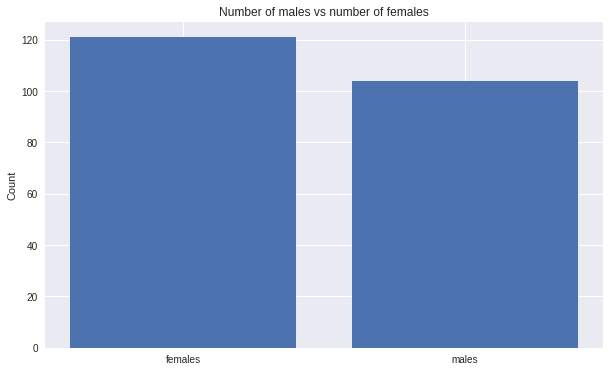

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.bar(["males", "females"], [n_males, n_females])
plt.title("Number of males vs number of females")
plt.ylabel("Count")
plt.show()

## Questions for Data Engineering

Now that we have a better feel for the data that we have been given, I want to start thinking about the feature extraction.

I would like to do a correlation plot, but that's not possible with the data in the format it it is in right now. I would need to do some feature engineering first to get everything in the right place.

So instead, I'll try and think about features that might be important and try and verify it. 

The question to be answered is "when is a user likely to unsubscribe from my services"?

* When their "use" of the platform starts to slow down.
* When they can't even use the platform due to erroes.
* When they decide to use another platform. (Not actionable)
* When they decide that they would rather save the money they spend on the service. (Not actionable)
* When friends start to ubsubscribe (network effects)
* When they listen to songs that they don't like

This means that I should check the following:

1. The distribution of those who visit the cancelation confirmation page and intra-session time.
2. Total play time per unit of time. Or even the number of pages visited per unit oftime.
3. If people are more likely to ubsubscribe if their direct friends unsubscribe.
4. Another useful signal is the number of error pages that they get. (Or event he number of times they check the help)
5. In addition to this, let's look at the ratio of likes vs dislikes.

### Find intrasession time correlation w/ cancellation

In [30]:
# Find intrasession time correlation w/ cancellation
response = spark.sql("""
    WITH usr_cancelsub AS (
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled
    FROM df_unique
    GROUP BY 1
    ),
    
    usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    )
    
    SELECT uc.*, ui.avg_intra_session_time
    FROM usr_cancelsub AS uc
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = uc.userId
""").collect()

In [31]:
intrasesh_times = [i.avg_intra_session_time for i in response]
is_canceled = [i.is_canceled for i in response]

df_intrasesh_cancelation = pd.DataFrame(dict(intrasesh_times = intrasesh_times,
                                            is_canceled = is_canceled))

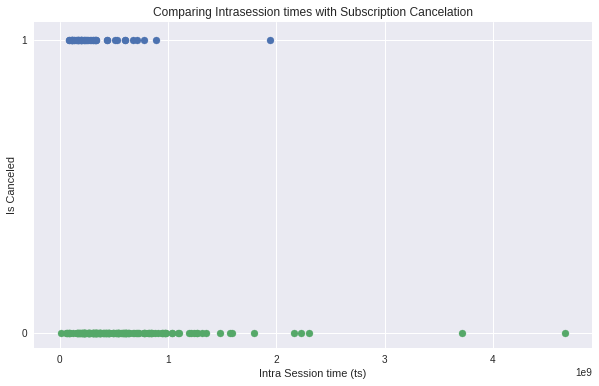

In [32]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 1]["intrasesh_times"], 
            df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 0]["intrasesh_times"], 
            df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Intrasession times with Subscription Cancelation")
plt.xlabel("Intra Session time (ts)")
plt.ylabel("Is Canceled")
plt.show()

We can see here that intrasesssion time tends to be lower for those who cancel their subscriptions. However, we are liable to get a lot of false positives if we take a simple rule that low intrasession times will cause someone to ubsubscribe. (Ofcourse, this is why we take multiple features.)

### Total play time correlation w/ Cancelation

In [33]:
# Find song long time correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(length) AS total_play_time
    FROM df_unique
    GROUP BY 1
""").collect()

In [34]:
total_play_time = [i.total_play_time for i in response]
is_canceled = [i.is_canceled for i in response]

df_playtime_cancelation = pd.DataFrame(dict(total_play_time = total_play_time,
                                            is_canceled = is_canceled))

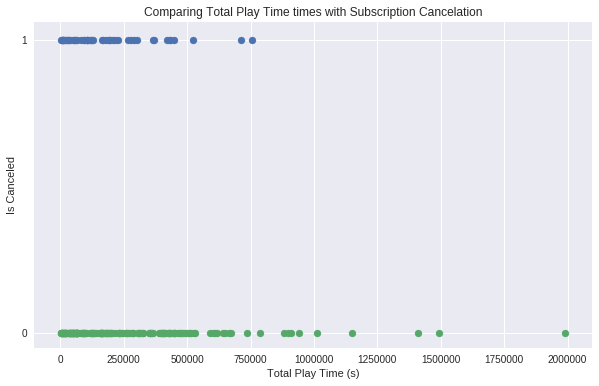

In [35]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["total_play_time"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["total_play_time"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Total Play Time times with Subscription Cancelation")
plt.xlabel("Total Play Time (s)")
plt.ylabel("Is Canceled")
plt.show()

So, it seems that this hypothesis was also true. We can see that the total amount of play time is also correlated with unsubscribing.

### Effect of network on unsubscribing

In [36]:
# Find song long time correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END) AS n_friends_added
    FROM df_unique
    GROUP BY 1
""").collect()

In [37]:
n_friends_added = [i.n_friends_added for i in response]
is_canceled = [i.is_canceled for i in response]

df_playtime_cancelation = pd.DataFrame(dict(n_friends_added = n_friends_added,
                                            is_canceled = is_canceled))

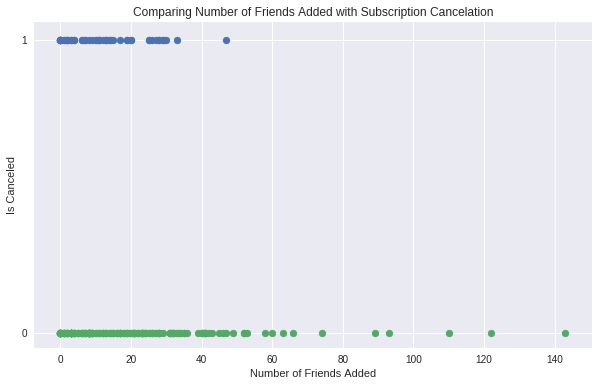

In [38]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["n_friends_added"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["n_friends_added"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Number of Friends Added with Subscription Cancelation")
plt.xlabel("Number of Friends Added")
plt.ylabel("Is Canceled")
plt.show()

Here, we can get a reoccuring theme that those with high numbers of friends are also unlikely to unsubscribe.

It seems that the reoccuring theme in these past couple of features is that the more engaged a user is with the sparkify platform, the less likely they are to unsubscribe.

### Analysis of Number of Error Pages

In [39]:
# Find error correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS n_errors
    FROM df_unique
    GROUP BY 1
""").collect()

In [40]:
n_errors = [i.n_errors for i in response]
is_canceled = [i.is_canceled for i in response]

df_errors = pd.DataFrame(dict(n_errors = n_errors,
                              is_canceled = is_canceled))

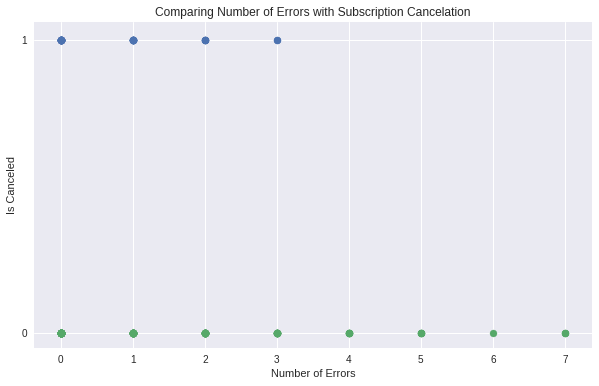

In [41]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_errors[df_errors["is_canceled"] == 1]["n_errors"], 
            df_errors[df_errors["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_errors[df_errors["is_canceled"] == 0]["n_errors"], 
            df_errors[df_errors["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Number of Errors with Subscription Cancelation")
plt.xlabel("Number of Errors")
plt.ylabel("Is Canceled")
plt.show()

We can see there that the number of errors is not strong enough of a singal to use as a feature. The number of people who have errors are relatively low AND it seems that there are people who stay described despite having more errors than those who don't.

This could just be a coincidince because the sample size is low. It is likely that this feature might still be worth having with the full dataset, but for this analysis we will leave it out.

### Ratio of Like/Dislike on unsubscribing

In [42]:
# Find error correlation w/ cancellation
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END)/
           SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END)AS Ratio_TU_v_TD
    FROM df_unique
    GROUP BY 1
""").collect()

In [43]:
Ratio_TU_v_TD = [i.Ratio_TU_v_TD for i in response]
is_canceled = [i.is_canceled for i in response]

df_TU_v_TD = pd.DataFrame(dict(Ratio_TU_v_TD = Ratio_TU_v_TD,
                              is_canceled = is_canceled))

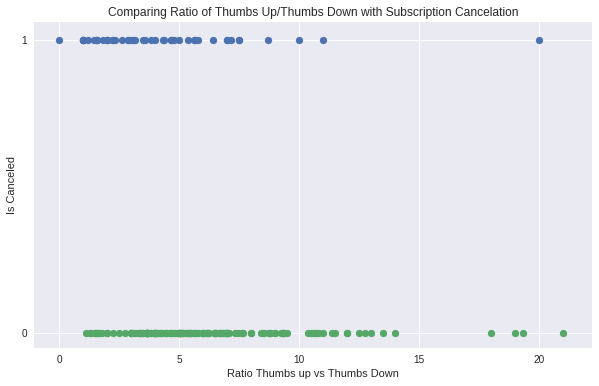

In [44]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_TU_v_TD[df_TU_v_TD["is_canceled"] == 1]["Ratio_TU_v_TD"], 
            df_TU_v_TD[df_TU_v_TD["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_TU_v_TD[df_TU_v_TD["is_canceled"] == 0]["Ratio_TU_v_TD"], 
            df_TU_v_TD[df_TU_v_TD["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Ratio of Thumbs Up/Thumbs Down with Subscription Cancelation")
plt.xlabel("Ratio Thumbs up vs Thumbs Down")
plt.ylabel("Is Canceled")
plt.show()

Once again, it seems we found another interesting feature. It seems that more people tend to upvote rather than downvote but still. 

# Part 3: Feature Engineering

In this section, the features that were most promising will be assembled into a vector to use for training the model. 

Before doing any engineering, we should consider what we want our X matrix (user-feature) and y vector (labels) to look like.

Obviously, X will be a matrix with user rows w/ features. These features will be either aggregated statistics for each user or whether they trigger some event.

Based on our EDA, we will use the following features for the columns in our X matrix:

1. Intra-session time.
2. Total play time
3. Number of Friends.
5. Ratio of likes vs dislikes.

This should give us a relatively simple model, but it should be a good start.

In [45]:
# Create SQL with Relevant Features
df_features_raw = spark.sql("""
    WITH usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    ) 

    SELECT du.userId,
           NVL(ui.avg_intra_session_time, 0) AS avg_intra_session_time,
           NVL(SUM(length), 0) AS total_play_time, 
           NVL(SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END), 0) AS n_friends_added,
           NVL(SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) /
               SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END), 0) AS Ratio_TU_v_TD,
           NVL(MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END), 0) AS label
    FROM df_unique AS du
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = du.userId
    GROUP BY 1, 2
""")

# Create Temp View
df_features_raw.createOrReplaceTempView("df_features_raw")

In [46]:
# Get columns
cols = df_features_raw.columns[1:-1]

# Create vector assembler
assembler = VectorAssembler(inputCols=cols, 
                            outputCol="DescVec")

df_features_unnormalised = assembler.transform(df_features_raw)

In [47]:
# Normalise features
scaler = Normalizer(inputCol="DescVec", outputCol="features")
df_features = scaler.transform(df_features_unnormalised).select(["features", "label"])

# Part 4: Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Create a base model

First, I want to throw my features into a model to see what kind of predictions I can get and then I want to make tweaks going from there.

In [48]:
# Perform Train Test split
train, validation = df_features.randomSplit([0.8, 0.2], seed=5318008)

**A note on the train validation split.**

It was found that the split of 90%:10% meant that the training set was too small and did not change at all with different models or by changing the features of the dataset.

Towards resolving this issue, I have decided to change the split to 80:20%

In [49]:
# Create logistic regression
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

crossval.setSeed(42)

if not os.path.isdir("./logisticRegression1"):
    
    print("Model not existing yet, training a new one...")
    
    # Get Start time
    train_time_start = time()
    
    # Train Model
    cvModel_lr = crossval.fit(train)

    # Get End time
    train_time_end = time()
    
    print("Training complete! \n\t Training time:", (train_time_end - train_time_start)/60, "mins.")
    
    # Save model for later
    cvModel_lr.save("./logisticRegression1")
else:
    print("Loading existing model")
    cvModel_lr = CrossValidatorModel.load("./logisticRegression1")

Loading existing model


I ran a larger grisearch which optimised at `elasticNetParam = 1.0` and `regParam = 1.0`

However, the grid was so large that the notebook couldn't complete before the kernel of the workspace timed out. I have reduced the size of the gridsearch for my own sanity. :) 

If there are more nodes in the cluster or if I was running on something more powerful than a VM then we could think about expanding the grid for the search agian.

## Evaluate Base Model

### Defining Metrics for Performance Measurement

Before going on to evaluate this model I would like to clearly define the metrics used to measure the performance of a model. 

When doing binary classifiation the obvious metric that everyone uses is "accuracy", which is defined in the equation below;

$$accuracy = \frac{t_p + t_n}{t_p + t_n + f_p + f_n}$$

Where $t_p$, $t_n$, $f_p$ and $f_n$ denote true positives, true negatives, false positives and false negatives respectively.

The only issue with this metric is that it is possible to get a high score in imblanced datasets by classifying everything as the major classification. (i.e. By classifying all users as not churning, in this example.)

Thus, we need metrics that don't include true negatives in the calculation.

This is why machine learning experts use these other metrics:

1. Precision
2. Recall

The equations for these metrics are defined down below:

$$precision = \frac{t_p}{t_p + f_p}$$

$$recall = \frac{t_p}{t_p + f_n}$$

You can also think about this from a conditional probability pespective

$$precision = p(t_p | pred = 1)$$

$$recall = p(t_p | label = 1)$$

However, I have the easiest time thinking about it like this:

* Precision = The number of positive classifications given that they WERE given positive classifications
* Recall = The number of positive classification given that that they SHOULD have been given positive classfications

We can see then that the difference between these two denotes how many false positive or false negatives are predicted, meaning that it is no longer enough to get a high accuracy, we need to minimise the number of false classifications.

Thus, if we have high precision and low recall, then the true positives we assign are likely to be correct but there are many examples that are true that we do not label correctly. (i.e. False negatives are over expressed) 

Inversely, if we have high recall but low precision then we do a good job assigning positive classifications to those observations that need it but we do so too willingly meaning that false positives are over expressed.

Sometimes it might be okay to value one metric over another in the case that having a false positive or a false negative is more painful than the other.

We can also take the harmonic mean of both of these metrics to create the $f_1$ score, which is a another good overall metric which captures information of precision and recall while not being able to be tricked in the same way that accuracy can.

$$f_1 = \frac{2(precision + recall)}{precision \times recall}$$

### Model Evaluation

Now that we have trained our first base model and defined/explained the metrics that we want to use, let's have a look at how it performs...

In [50]:
train_results = cvModel_lr.transform(train)

# Get Validation claffications
tp_train = train_results.filter("label = 1 and prediction = 1").count()
fp_train = train_results.filter("label = 0 and prediction = 1").count()
fn_train = train_results.filter("label = 1 and prediction = 0").count()
tn_train = train_results.filter("label = 0 and prediction = 0").count()

# Group into list
test_classifications = [tp_train, 
                        tn_train, 
                        fp_train, 
                        fn_train]

In [51]:
print_cm(*test_classifications)

[[  2   0]
 [ 40 135]]


In [52]:
get_classification_score(*test_classifications)

_________________
Confusion Matrix:
	Accuracy: 0.7740112994350282
	Precision: 1.0
	Recall: 0.047619047619047616
	F1 Score: 0.0909090909090909
_________________


In [53]:
validation_results = cvModel_lr.transform(validation)

# Get Validation claffications
tp_valid = validation_results.filter("label = 1 and prediction = 1").count()
fp_valid = validation_results.filter("label = 0 and prediction = 1").count()
fn_valid = validation_results.filter("label = 1 and prediction = 0").count()
tn_valid = validation_results.filter("label = 0 and prediction = 0").count()

# Group into list
valid_classifications = [tp_valid, 
                         tn_valid, 
                         fp_valid, 
                         fn_valid]

In [54]:
print_cm(*valid_classifications)

[[ 0  2]
 [ 9 38]]


In [55]:
get_classification_score(*valid_classifications)

_________________
Confusion Matrix:
	Accuracy: 0.7755102040816326
	Precision: 0.0
	Recall: 0.0
	F1 Score: nan
_________________


We can see that his model doesn't perform particularly well. Despite getting a validation accuracy of 79%, our precision and recall are either zero or undefined. 

We can see from our confusion matrix that this model simply classified all users as not churning. This will create a true negative rate that we want but it won't give us good positive results.

Even if we look at the training scores, it is not particularly great. Allthough we have good precision, our recall is pretty low meaning that there are a lot of positive examples that we are missing.

This could be because are model is relatively high bias and so making complicated judgments is relatively difficult. If we view the graphs back in the exporatory data analysis section then we can also see that there is a strong overlap between churners and non-churners, meaning that the model will likely have an easier time finding non-churners where the separation is better.

It should also be mentioned that the number of rows and features are also very low. We are working with roughly 250 observations which is not very high, so one of the first orders to do would also be to run this on the whole cluster before adding more features and then finally increasing the model complexity as a last resort.

This means that to improve this model we can do three things:


1. Move this analysis onto a cluster using the full dataset
2. Engineer more features to help distinguish between churn and non churn users
3. Use a higher variance model

Before going back to refine the feature engineering, let's have a look at some coeficients.

In [56]:
# Print the coefficients and intercept for logistic regression

df_lr_coeff = pd.DataFrame(dict(feature = df_features_raw.columns[1:-1]+["Intercept"],
                                coefficient = [i for i in cvModel_lr.bestModel.coefficients]+\
                                [i for i in [cvModel_lr.bestModel.intercept]]))

# Pring DataFrame
df_lr_coeff.sort_values("coefficient", ascending=False)

,feature,coefficient
3,Ratio_TU_v_TD,5479.160452
2,n_friends_added,1720.411792
0,avg_intra_session_time,0.000000
1,total_play_time,0.000000
4,Intercept,-1.224377


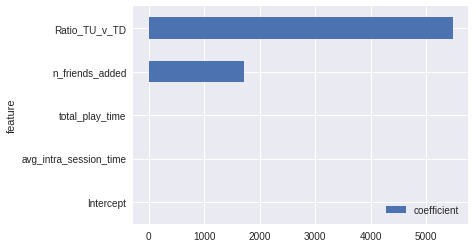

In [57]:
# Plot Values
df_lr_coeff.sort_values("coefficient", ascending=True).set_index("feature").plot(kind="barh");

The features with the highest coefficients are the n_friends added and ratio of thumbs up vs thumbs down. The average intra session time and total play time did not appear to play as much of a role. So it seems that people will stay churn somewhat depending on their social interactions and *how much they like the music that they are listening to*.

So here are some features I would suggest adding:

1. Number of Artists Listened to
2. Number of Songs Added to Playlist

## Improve Upon Base Model

### Revisit Feature Engineering

Task: Add number of artists and Number of Songs Listened

In [58]:
df_unique.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'rank']

In [59]:
# Create SQL with Relevant Features
df_features_raw2 = spark.sql("""
    WITH usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    ) 

    SELECT du.userId,
           NVL(ui.avg_intra_session_time, 0) AS avg_intra_session_time,
           NVL(SUM(length), 0) AS total_play_time, 
           NVL(SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END), 0) AS n_friends_added,
           NVL(SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) /
               SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END), 0) AS Ratio_TU_v_TD,
           NVL(COUNT(DISTINCT artist), 0) AS n_artists,
           NVL(COUNT(song), 0) AS n_songs,
           NVL(SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END), 0) AS n_added_to_playlist,
           NVL(MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END), 0) AS label
    FROM df_unique AS du
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = du.userId
    GROUP BY 1, 2
""")

# Create Temp View
df_features_raw.createOrReplaceTempView("df_features_raw2")

In [60]:
# Get columns
cols = df_features_raw2.columns[1:-1]

# Create vector assembler
assembler = VectorAssembler(inputCols=cols, 
                            outputCol="DescVec")

df_features_unnormalised2 = assembler.transform(df_features_raw2)

In [61]:
# Normalise features
df_features2 = scaler.transform(df_features_unnormalised2).select(["features", "label"])

### Try again on Base Model



In [62]:
# Perform Train Test split
train2, validation2 = df_features2.randomSplit([0.8, 0.2], seed=5318008)

In [63]:
if not os.path.isdir("./logisticRegression2"):
    
    print("Model not existing yet, training a new one...")
    
    # Get Start time
    train_time_start = time()
    
    # Train Model
    cvModel_lr2 = crossval.fit(train)

    # Get End time
    train_time_end = time()
    
    print("Training complete! \n\t Training time:", (train_time_end - train_time_start)/60, "mins.")
    
    # Save model for later
    cvModel_lr2.save("./logisticRegression2")
else:
    print("Loading existing model")
    cvModel_lr2 = CrossValidatorModel.load("./logisticRegression2")

Loading existing model


In [64]:
# Assess Training results
train_results2 = cvModel_lr2.transform(train2)

# Get Validation claffications
tp_train2 = train_results2.filter("label = 1 and prediction = 1").count()
fp_train2 = train_results2.filter("label = 0 and prediction = 1").count()
fn_train2 = train_results2.filter("label = 1 and prediction = 0").count()
tn_train2 = train_results2.filter("label = 0 and prediction = 0").count()

# Group into list
train_classifications2 = [tp_train2, 
                        tn_train2, 
                        fp_train2, 
                        fn_train2]

In [65]:
print_cm(*train_classifications2)

[[ 11   1]
 [ 31 134]]


In [66]:
get_classification_score(*train_classifications2)

_________________
Confusion Matrix:
	Accuracy: 0.8192090395480226
	Precision: 0.9166666666666666
	Recall: 0.2619047619047619
	F1 Score: 0.4074074074074074
_________________


In [67]:
# Assess Validation Results
valid_results2 = cvModel_lr2.transform(validation2)

# Get Validation claffications
tp_valid2 = valid_results2.filter("label = 1 and prediction = 1").count()
fp_valid2 = valid_results2.filter("label = 0 and prediction = 1").count()
fn_valid2 = valid_results2.filter("label = 1 and prediction = 0").count()
tn_valid2 = valid_results2.filter("label = 0 and prediction = 0").count()

# Group into list
valid_classifications2 = [tp_valid2, 
                          fp_valid2, 
                          fn_valid2, 
                          tn_valid2]

In [68]:
print_cm(*valid_classifications2)

[[ 0  9]
 [34  6]]


In [69]:
get_classification_score(*valid_classifications2)

_________________
Confusion Matrix:
	Accuracy: 0.12244897959183673
	Precision: 0.0
	Recall: 0.0
	F1 Score: nan
_________________


In [70]:
# Print the coefficients and intercept for logistic regression
df_lr_coeff2 = pd.DataFrame(dict(feature = df_features_raw2.columns[1:-1]+["Intercept"],
                                coefficient = [i for i in cvModel_lr2.bestModel.coefficients]+\
                                [i for i in [cvModel_lr2.bestModel.intercept]]))

# Pring DataFrame
df_lr_coeff2.sort_values("coefficient", ascending=False)

,feature,coefficient
3,Ratio_TU_v_TD,1.440863e+07
6,n_added_to_playlist,3.333629e+06
2,n_friends_added,2.294887e+06
4,n_artists,1.848254e+06
1,total_play_time,7.062210e+03
0,avg_intra_session_time,3.781447e+03
7,Intercept,-3.783353e+03
5,n_songs,-3.056069e+06


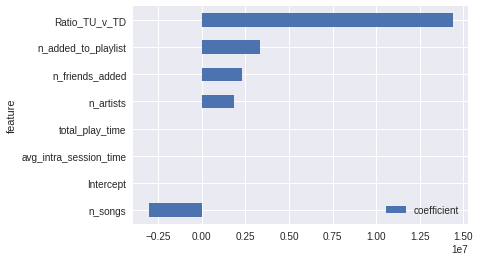

In [71]:
# Plot Values
df_lr_coeff2.sort_values("coefficient", ascending=True).set_index("feature").plot(kind="barh");

We can see that adding some new features did not do a lot to help the model. It is a slight improvement that the logistic regress doesn't simply classify everything as being negative but there are still issues  when it comes to false positives and false negatives.

Let's try this dataset on another model and see how it fares. It might just be that a logistic regression does not have the amount of variation required within the model to predict on this dataset very well.

### Alternative: Model Decision Tree

In [72]:
# Create Decision Tree
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

crossval.setSeed(42)

if not os.path.isdir("./decisionTree1"):
    
    print("Model not existing yet, training a new one...")
    
    # Get Start time
    train_time_start = time()
    
    # Train Model
    cvModel_dt = crossval_dt.fit(train)

    # Get End time
    train_time_end = time()
    
    print("Training complete! \n\t Training time:", (train_time_end - train_time_start)/60, "mins.")
    
    # Save model for later
    cvModel_dt.save("./decisionTree1")
else:
    print("Loading existing model")
    cvModel_dt = CrossValidatorModel.load("./decisionTree1")

Loading existing model


In [73]:
# Assess results for test set
train_results2 = cvModel_dt.transform(train2)

# Get Validation claffications
tp_train2 = train_results2.filter("label = 1 and prediction = 1").count()
fp_train2 = train_results2.filter("label = 0 and prediction = 1").count()
fn_train2 = train_results2.filter("label = 1 and prediction = 0").count()
tn_train2 = train_results2.filter("label = 0 and prediction = 0").count()

# Group into list
test_classifications2 = [tp_train2, 
                        tn_train2, 
                        fp_train2, 
                        fn_train2]

In [74]:
print_cm(*test_classifications2)

[[ 35  11]
 [  7 124]]


In [75]:
get_classification_score(*test_classifications2)

_________________
Confusion Matrix:
	Accuracy: 0.8983050847457628
	Precision: 0.7608695652173914
	Recall: 0.8333333333333334
	F1 Score: 0.7954545454545455
_________________


In [76]:
# Assess results for validation set
valid_results2 = cvModel_dt.transform(validation2)

# Get Validation claffications
tp_valid2 = valid_results2.filter("label = 1 and prediction = 1").count()
fp_valid2 = valid_results2.filter("label = 0 and prediction = 1").count()
fn_valid2 = valid_results2.filter("label = 1 and prediction = 0").count()
tn_valid2 = valid_results2.filter("label = 0 and prediction = 0").count()

# Group into list
valid_classifications2 = [tp_valid2, 
                         tn_valid2, 
                         fp_valid2, 
                         fn_valid2]

In [77]:
print_cm(*valid_classifications2)

[[ 2 13]
 [ 7 27]]


In [78]:
get_classification_score(*valid_classifications2)

_________________
Confusion Matrix:
	Accuracy: 0.5918367346938775
	Precision: 0.13333333333333333
	Recall: 0.2222222222222222
	F1 Score: 0.16666666666666669
_________________


In [79]:
cvModel_dt.bestModel._java_obj.getImpurity(), cvModel_dt.bestModel._java_obj.getMaxDepth()

('entropy', 7)

We can see here that choosing a different algorithm did quite a lot to improve our score.

Now, it might be a little weird to think of this as an improvement but the reason why I say so is because at least my precision and recall are values greater than zero. Although accuracy took a hit, the fact of the matter is that before I wasn't getting any true positive classifications.

The fact that this tree has a depth of 8 as well shows that a model with a little higher variance than a logistic regression can go a long way to improving the model. 

The next place to focus would be on engineering more features so that the number of false positives and false negatives go down. This might require more experimentation with other models but I would also like to get rid of features that don't contribute much to the model. 

### Checking Decision Tree's Robustness

One final question that I would like to answer is in regard to how stable the model is. To answer this question I will perform train/test splits on the dataset using different seeds and, train the model based on the optimal hyperparameters printed above and then aggregate the resultant metrics (accuracy, precision, recall, f1, etc.) to get their means and deviations.

In [80]:
if not os.path.isfile("./robustness_test.csv"):
    robust_dict = dict(seed = [],
                            accuracy = [],
                            precision = [],
                            recall = [],
                            f1 = [])

    for i in trange(10):

        # Create tree for robustness testing
        dt_robust_test = DecisionTreeClassifier(impurity=cvModel_dt.bestModel._java_obj.getImpurity(),
                                                maxDepth = cvModel_dt.bestModel._java_obj.getMaxDepth())

        # Create Dataset for robustness testing
        train_robust, validation_robust = df_features2.randomSplit([0.8, 0.2], seed=i)

        # Train Model
        dt_robust_test = dt_robust_test.fit(train_robust)

        # Predict on Validation Data
        # Assess results for validation set
        valid_results_robust = dt_robust_test.transform(validation_robust)

        # Get Validation claffications
        tp_robust = valid_results_robust.filter("label = 1 and prediction = 1").count()
        fp_robust = valid_results_robust.filter("label = 0 and prediction = 1").count()
        fn_robust = valid_results_robust.filter("label = 1 and prediction = 0").count()
        tn_robust = valid_results_robust.filter("label = 0 and prediction = 0").count()

        # Get metrics
        acc, prec, recall, f1 = get_classification_score(tp_robust, 
                                                         fp_robust, 
                                                         fn_robust, 
                                                         tn_robust, 
                                                         print_stats=False, 
                                                         return_stats=True)
        robust_dict["seed"].append(i)
        robust_dict["accuracy"].append(acc)
        robust_dict["precision"].append(prec)
        robust_dict["recall"].append(recall)
        robust_dict["f1"].append(f1)

    df_robust = pd.DataFrame(robust_dict)

    # Save df_robust
    df_robust.to_csv("./robustness_test.csv", index=False)
    
else:
    print("Importing already completed test")
    df_robust = pd.read_csv("./robustness_test.csv")

Importing already completed test


In [81]:
# Print out table with mean and std for each mextric
df_robust.describe().reset_index().query("index in ['mean', 'std']")

,index,seed,accuracy,precision,recall,f1
1,mean,4.50000,0.158851,0.253846,0.070165,0.108664
2,std,3.02765,0.090596,0.119084,0.038345,0.055646


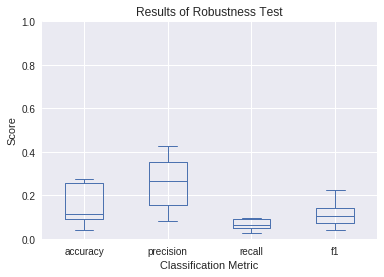

In [82]:
# Create box plot
ax = df_robust[["accuracy", "precision", "recall", "f1"]].plot(kind='box', color=color_cycle[0])
plt.title("")
plt.ylim(0, 1)
plt.title("Results of Robustness Test")
plt.xlabel("Classification Metric")
plt.ylabel("Score")
plt.show()

We can see that the model performs consistently poorly. The recall doesn't budge above 0.2 which means that we miss a lot of observations that should be labeled as being a positive classification.

Precision tends to be a little higher, which makes sense because it is difficult to predict when someone will churn. It is surprising that the accuracy is so low, this would be because we are getting a lot of false positives and false negatives which will also be why the precision and recall is low as well.

If it is difficult to predict when someone will churn then we either need to feed the model more data by sizing up to a full cluster, add features that provide different patterns of data to what we have already submitted or increase complexity of our model. These are the things I would focus on to improve.

# Part 5: Conclusion

## Reflection

In this project, we took some data from the sparkify platform and checked it for duplicated and missing data. It was found that the data was mostly clean despite some duplication.

Afterwards some basic EDA was done to find which columns within the dataset should be focused on. It was found that pages contained the most interesting information along with some of the details with songs that could be found in the relevant columns.

After trying to think about what kind of things would cause someone to leave a service, a number of features were suggested and verified. These were intrasession time, number of songs added to playlists, number of friends added, and  the ratio of thumbs up to thumbs down. Other suggested features such as the number of errors werent numerous enough to use and so they were left behind.

After doing some initial fitting of a logistic regression model, it was found that the score was not very high this was due to various reasons.

1. Logistic regressions don't seem to perform well on this dataset
2. There were still a number of features that I could add to add some variation with which to distinguish users
3. The validation set was relatively small and I felt that a bigger one would give a better picture of how the model was generalising. (It is worth noting that 250 observations is really small and for true performances of these models, we would need to scale up so that the number of observations surpasses at least 1000.)

## Difficulties

What I found most difficult about this investigation was geting used to working with Spark instead of using SKLearn. I got around this with a lot of googling and depending a lot on spark's sql functions, allowing me to make use of my knowledge of SQL.

Another thing I found difficult is models taking a long time to train. This more of a drawback of using a VM and not having a large cluster of computers to make computation speed a little faster. 


## Improvement

I believe that looking at other models and doing some more feature engineering will help to bring this model a little further. However, getting a top notch model is beyond the scope of this project.

Furthermore, I think that if the number of observations were to increase, we could start thinking about using undersampling in order to help with the class imbalance. I an curious to see what the outcomes of this would be. 

Having more computational power would also allow us to search over a wider area with grid search, possibly allowing for better models.